In [1]:
import os, sys
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import torch
from torchvision.models import alexnet, vgg19, inception_v3, resnet50
import timm
from torch.utils.data import Dataset, DataLoader
from thop import profile
from tool import trainer, imageDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import gc
torch.__version__

'2.0.0+cu117'

In [2]:
RANDOM_STATE = 111
BATCH_SIZE = 1
EPOCHS = 10
LR = 1e-4
TEST_SIZE = 0.15

### 讀取資料

In [3]:
dir_path = './data/'
dir_list = ['normal', 'osteopenia', 'osteoporosis']

data_path, labels = [], []
for index, item in enumerate(dir_list):
    images = os.listdir(dir_path + item)
    for image in images:
        if image[0] != '.':
            data_path.append(dir_path + item + '/' + image)
            labels.append(index)

print(f'資料共{len(data_path)}筆')

資料共239筆


### 資料前處理

In [4]:
def data_preprocess(paths):
    features = []
    for path in tqdm(paths):
        # 讀取image，並轉為灰階影像
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))
        img = np.transpose(img, (2, 0, 1)).astype('float32')
        # 標準化(MaxAbs)，灰階影像最大為255
        img = img / 255
        features.append(img)
        
    return features

### OneHotEncoding

In [5]:
# 轉成np.array再轉成oneHotEncoding
def OneHotEncoding(labels):
    y = np.eye(3)[np.array(list(map(int, labels)))]
    return y

### 切分資料

In [6]:
%%time
X_train, X_valid, Y_train, Y_valid = train_test_split(data_path, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f'訓練資料共{len(X_train)}筆')
print(f'驗證資料共{len(X_valid)}筆')

訓練資料共203筆
驗證資料共36筆
CPU times: user 1.16 ms, sys: 85 µs, total: 1.24 ms
Wall time: 933 µs


### Data Preocess and set DataLoader

In [7]:
%%time
train_data = imageDataset(data_preprocess(X_train), OneHotEncoding(Y_train))
val_data = imageDataset(data_preprocess(X_valid), OneHotEncoding(Y_valid))

# set device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# set the DataLoader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(val_data, batch_size=36, shuffle = False)

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 5.3 s, sys: 415 ms, total: 5.72 s
Wall time: 5.72 s


In [9]:
!nvidia-smi

Sun Jun 11 22:19:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 25%   46C    P0    39W / 125W |   1322MiB /  6144MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 各模型比較

In [10]:
input,output = next(iter(train_loader))
print(input.shape)
print(output)
input = input.to(device)
output = output.to(device)

def show_feature_map(layer,input,output):
    feature_map = layer.forward(input)
    print(output)

    # Show the feature map
    feature_image = feature_map.squeeze().cpu().detach().numpy()
    print(feature_image.shape)
    plt.figure(figsize=(20, 20))
    for i in range(36):
        plt.subplot(6, 6, i+1)
        plt.imshow(normalize(feature_image[i]), cmap='gray')
        plt.axis('off') 


torch.Size([1, 3, 224, 224])
tensor([[0., 1., 0.]], dtype=torch.float64)


In [12]:
!nvidia-smi

Sun Jun 11 22:19:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 25%   47C    P2    41W / 125W |   1629MiB /  6144MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### alexnet
- https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet

/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--------------------Epoch 1--------------------
Train_accuracy: 61.58% | Train_loss: 194.8258
--------------------Epoch 2--------------------
Train_accuracy: 64.04% | Train_loss: 179.6832
--------------------Epoch 3--------------------
Train_accuracy: 63.55% | Train_loss: 170.0078
--------------------Epoch 4--------------------
Train_accuracy: 64.04% | Train_loss: 168.2054
--------------------Epoch 5--------------------
Train_accuracy: 65.52% | Train_loss: 157.3574
--------------------Epoch 6--------------------
Train_accuracy: 65.02% | Train_loss: 147.3028
--------------------Epoch 7--------------------
Train_accuracy: 69.46% | Train_loss: 140.2513
--------------------Epoch 8--------------------
Train_accuracy: 73.89% | Train_loss: 128.5539
--------------------Epoch 9--------------------
Train_accuracy: 76.35% | Train_loss: 117.8863
--------------------Epoch 10--------------------
Train_accuracy: 79.80% | Train_loss: 108.1439


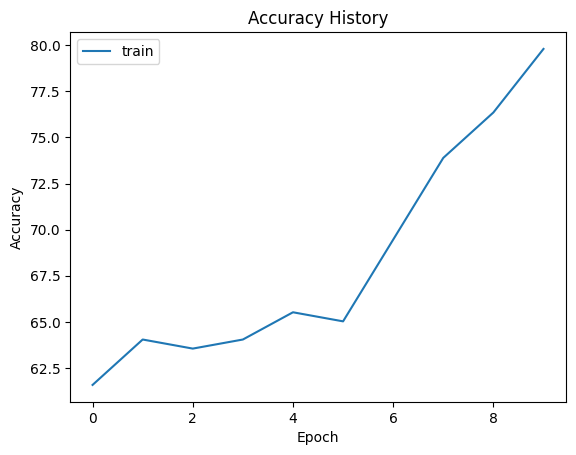

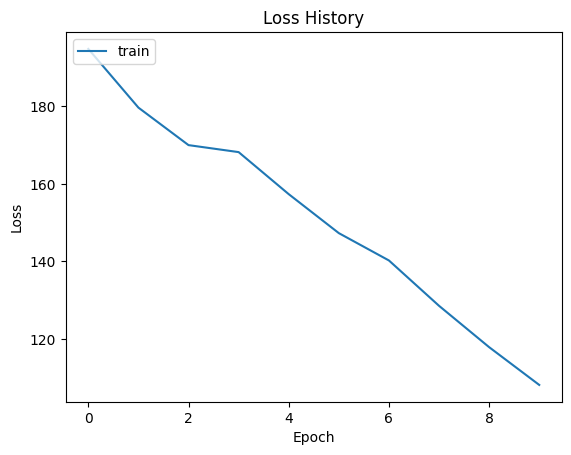

Accuracy on the test images: 50.00%
Inference time: 15.5545 milliseconds


In [13]:
# pre-trained model(https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet)
model = alexnet(pretrained=True).to(device)
# Modify the last layer(num_classes: 1000 => 3), Replace the last layer with a new fully connected layer with 3 output units(ChatGPT)
model.classifier[6] = torch.nn.Linear(4096, 3).to(device)
alexnet_trainer = trainer(model, train_loader, test_loader, EPOCHS, 1e-5)
# train process
alexnet_trainer.train()
alexnet_trainer.predict()

In [15]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
torch.Size([1, 64, 27, 27])
(64, 27, 27)


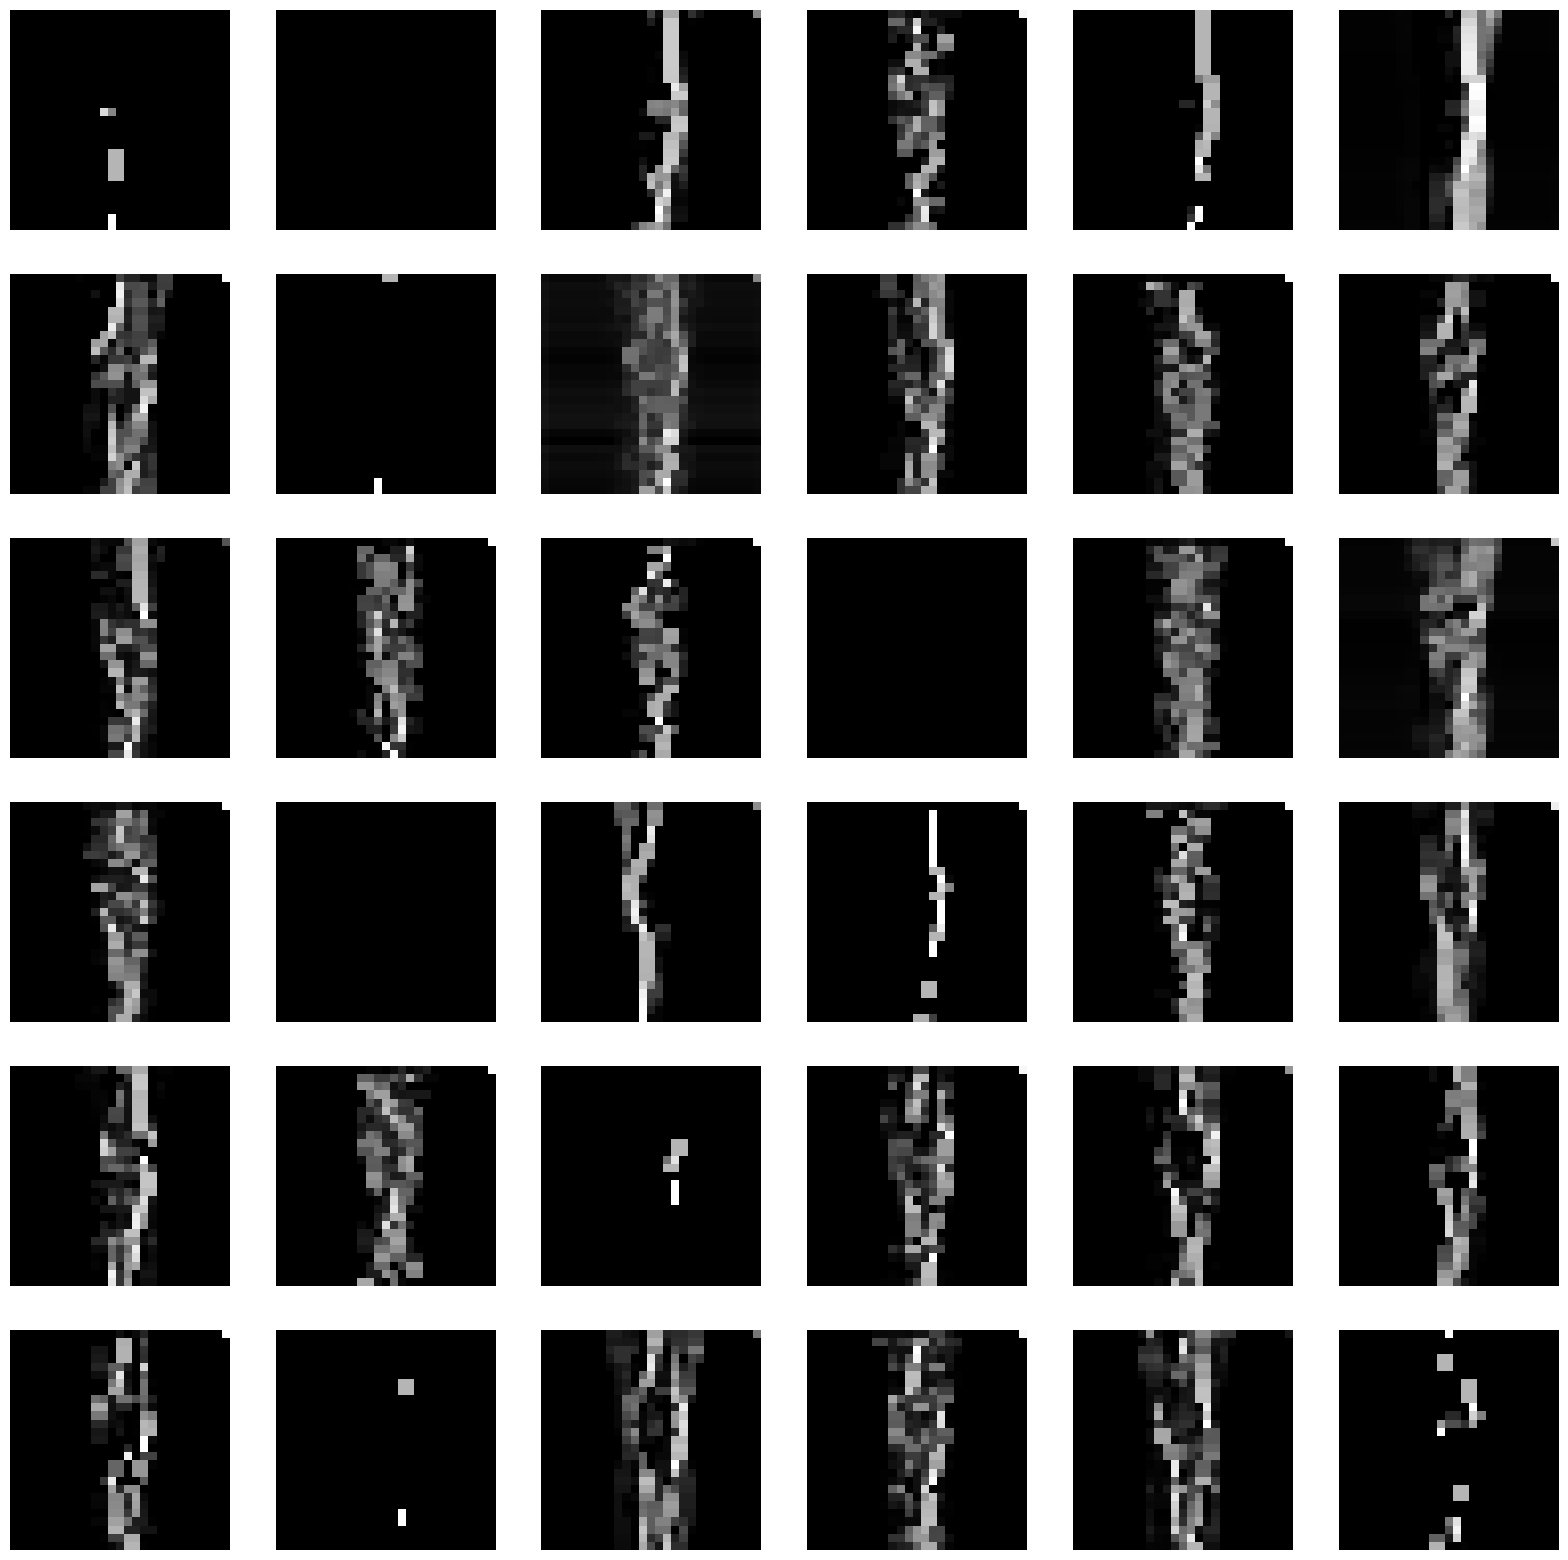

In [20]:
# Show the feature map
layer1 = model.features[0]
layer2 = model.features[1]
layer3 = model.features[2]

# feature_model = model
# feature_model.features[-1] = []
feature_map = layer1.forward(input)
feature_map = layer2.forward(feature_map)
feature_map = layer3.forward(feature_map)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(normalize(feature_image[i]), cmap='gray')
    plt.axis('off') 


In [14]:
!nvidia-smi

Sat Jun 10 04:00:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 45%   66C    P2    56W / 125W |   3340MiB /  6144MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
del model, alexnet_trainer, feature_map
gc.collect()
torch.cuda.empty_cache()

In [16]:
!nvidia-smi

Sat Jun 10 04:00:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 45%   66C    P2    58W / 125W |   2050MiB /  6144MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### VGG19
- https://pytorch.org/vision/0.11/models.html?highlight=vgg19#torchvision.models.vgg19

/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--------------------Epoch 1--------------------
Train_accuracy: 63.55% | Train_loss: 282.6562
--------------------Epoch 2--------------------
Train_accuracy: 64.53% | Train_loss: 193.3616
--------------------Epoch 3--------------------
Train_accuracy: 64.53% | Train_loss: 188.9287
--------------------Epoch 4--------------------
Train_accuracy: 64.53% | Train_loss: 234.1163
--------------------Epoch 5--------------------
Train_accuracy: 64.53% | Train_loss: 186.7175
--------------------Epoch 6--------------------
Train_accuracy: 64.53% | Train_loss: 187.2669
--------------------Epoch 7--------------------
Train_accuracy: 64.53% | Train_loss: 192.8127
--------------------Epoch 8--------------------
Train_accuracy: 64.53% | Train_loss: 183.7004
--------------------Epoch 9--------------------
Train_accuracy: 64.53% | Train_loss: 184.2323
--------------------Epoch 10--------------------
Train_accuracy: 64.53% | Train_loss: 181.8155


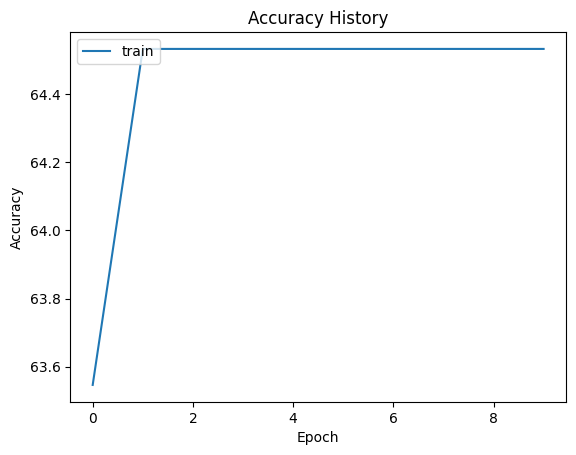

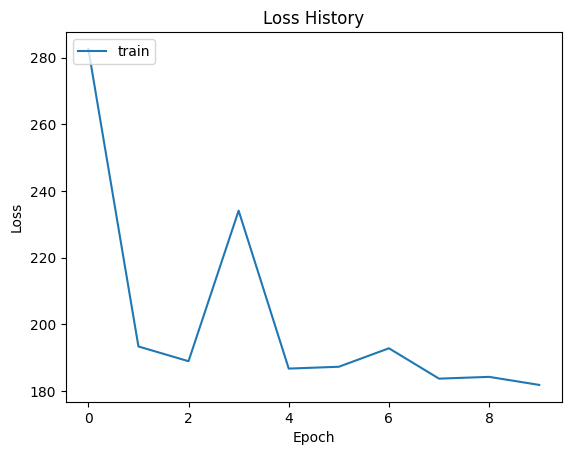

Accuracy on the test images: 63.89%
Inference time: 343.2234 milliseconds


In [17]:
model = vgg19(pretrained=True).to(device)
model.classifier[6] = torch.nn.Linear(4096, 3).to(device)
vgg19_trainer = trainer(model, train_loader, test_loader, EPOCHS, 1e-4)
vgg19_trainer.train()
vgg19_trainer.predict()

In [18]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 224, 224])
(64, 224, 224)


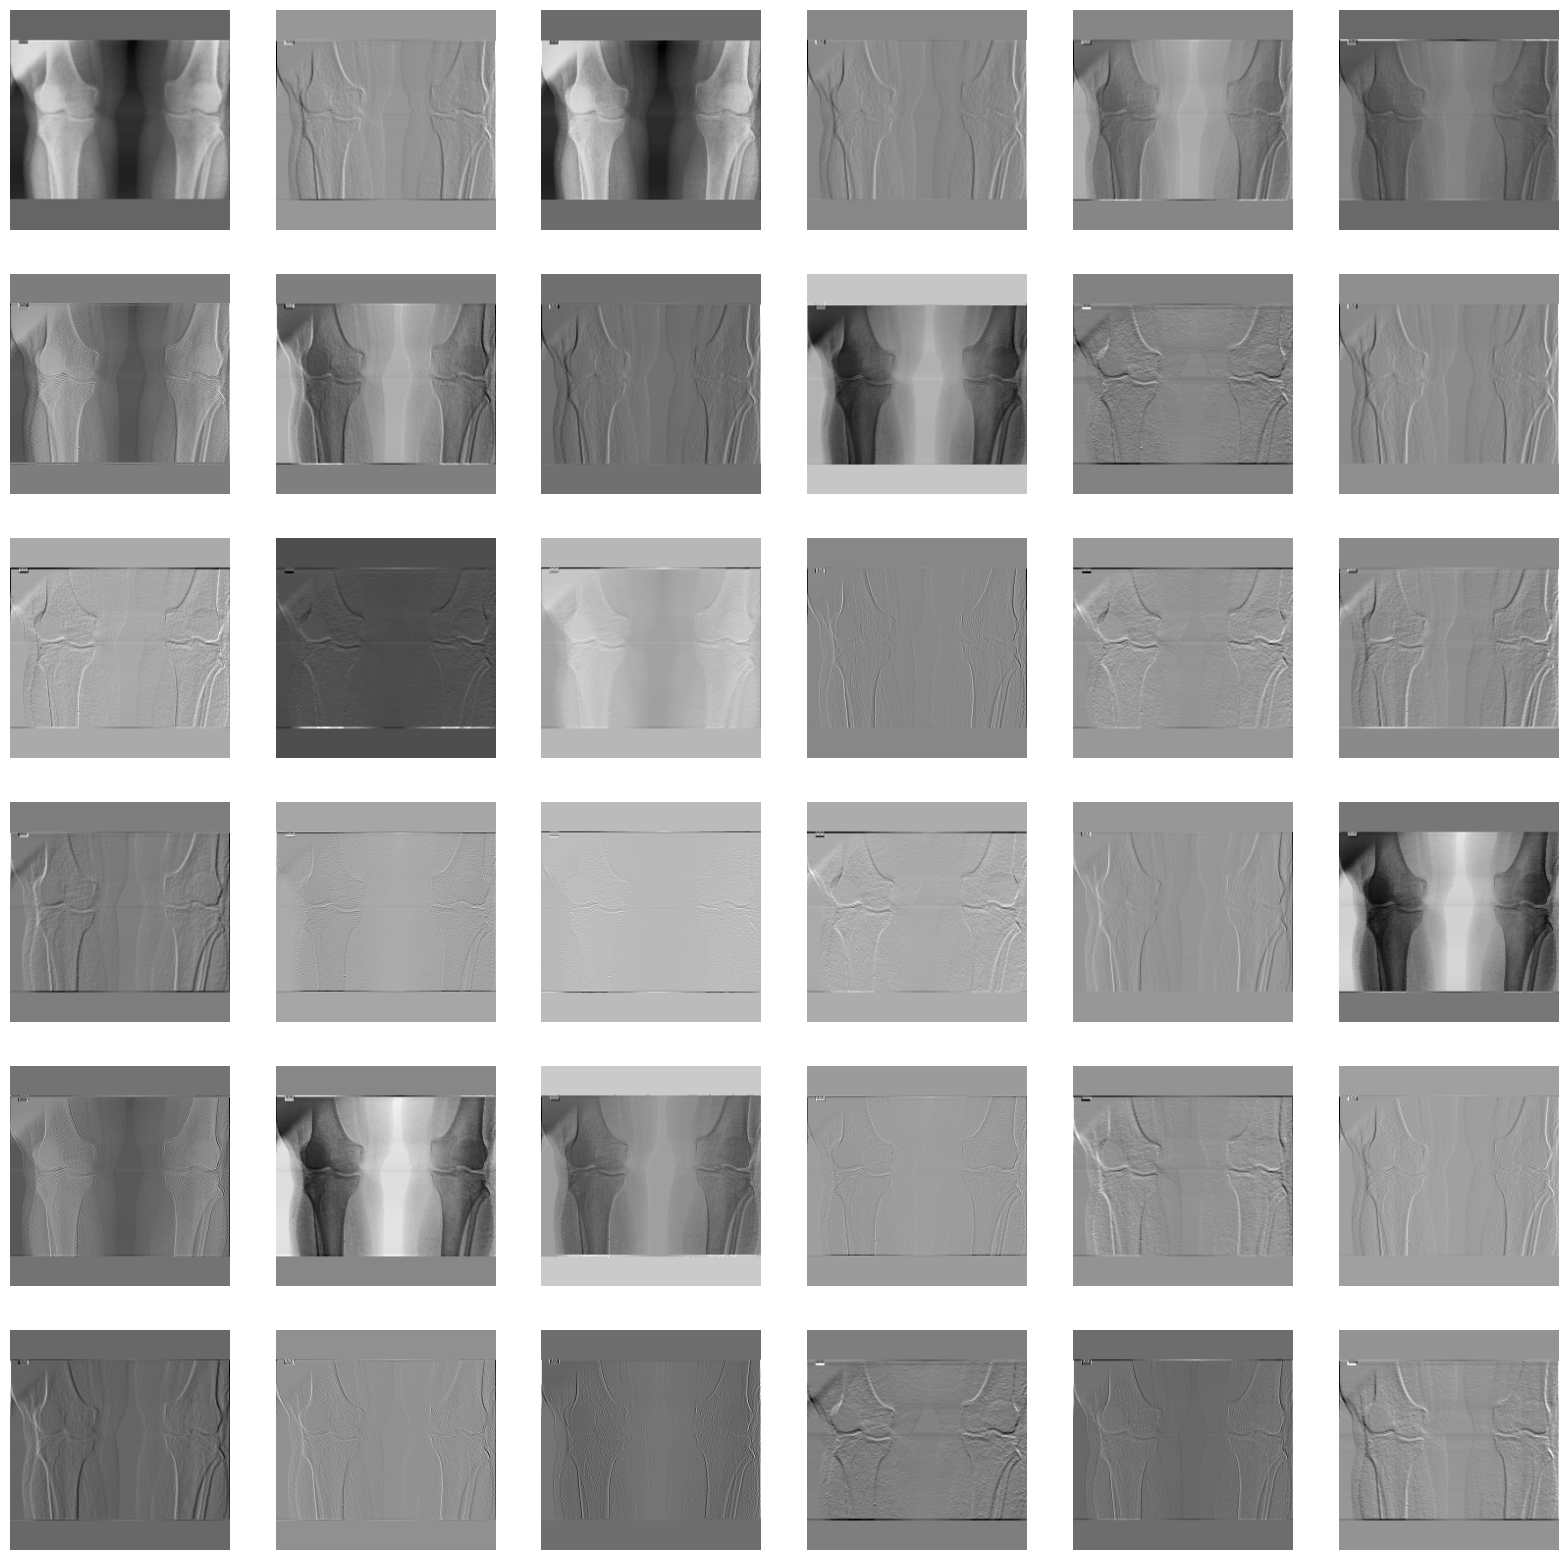

In [19]:
# Show the feature map
layer1 = model.features[0]
feature_map = layer1.forward(input)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(normalize(feature_image[i]), cmap='gray')
    plt.axis('off') 

In [20]:
!nvidia-smi

Sat Jun 10 04:02:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 47%   68C    P2    55W / 125W |   5687MiB /  6144MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
del model, vgg19_trainer, feature_map
gc.collect()
torch.cuda.empty_cache()

In [22]:
!nvidia-smi

Sat Jun 10 04:02:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 47%   68C    P2    58W / 125W |   3129MiB /  6144MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### resnet50
- https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet

/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--------------------Epoch 1--------------------
Train_accuracy: 64.53% | Train_loss: 187.4996
--------------------Epoch 2--------------------
Train_accuracy: 64.53% | Train_loss: 169.4908
--------------------Epoch 3--------------------
Train_accuracy: 64.53% | Train_loss: 159.1143
--------------------Epoch 4--------------------
Train_accuracy: 64.53% | Train_loss: 152.0120
--------------------Epoch 5--------------------
Train_accuracy: 64.53% | Train_loss: 146.5294
--------------------Epoch 6--------------------
Train_accuracy: 64.53% | Train_loss: 140.5774
--------------------Epoch 7--------------------
Train_accuracy: 64.53% | Train_loss: 135.8934
--------------------Epoch 8--------------------
Train_accuracy: 65.02% | Train_loss: 130.6801
--------------------Epoch 9--------------------
Train_accuracy: 65.02% | Train_loss: 126.1645
--------------------Epoch 10--------------------
Train_accuracy: 65.52% | Train_loss: 121.9019


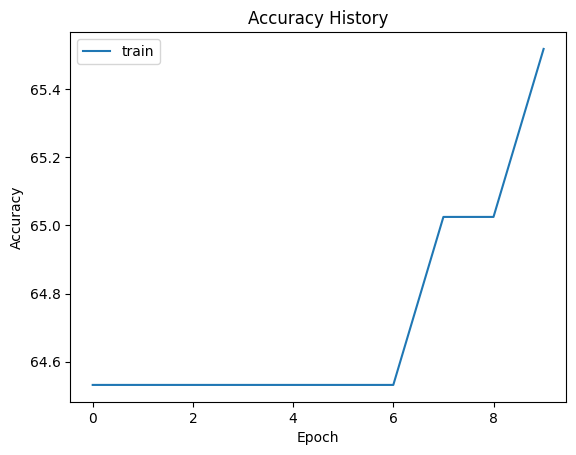

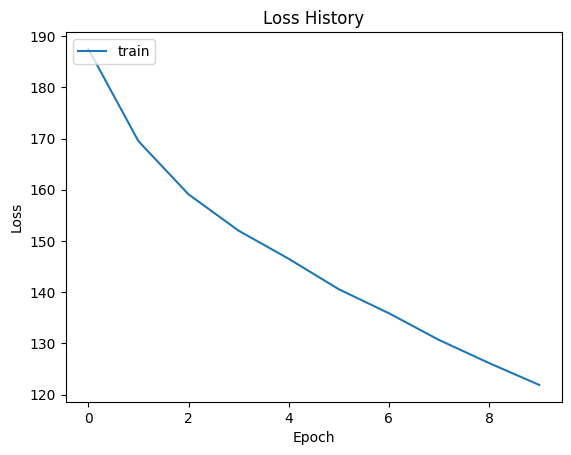

Accuracy on the test images: 63.89%
Inference time: 117.2996 milliseconds


In [23]:
model = resnet50(pretrained=True).to(device)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 3).to(device)

resnet_trainer = trainer(model, train_loader, test_loader, EPOCHS, 5e-6)
resnet_trainer.train()
resnet_trainer.predict()

In [24]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 56, 56])
(64, 56, 56)


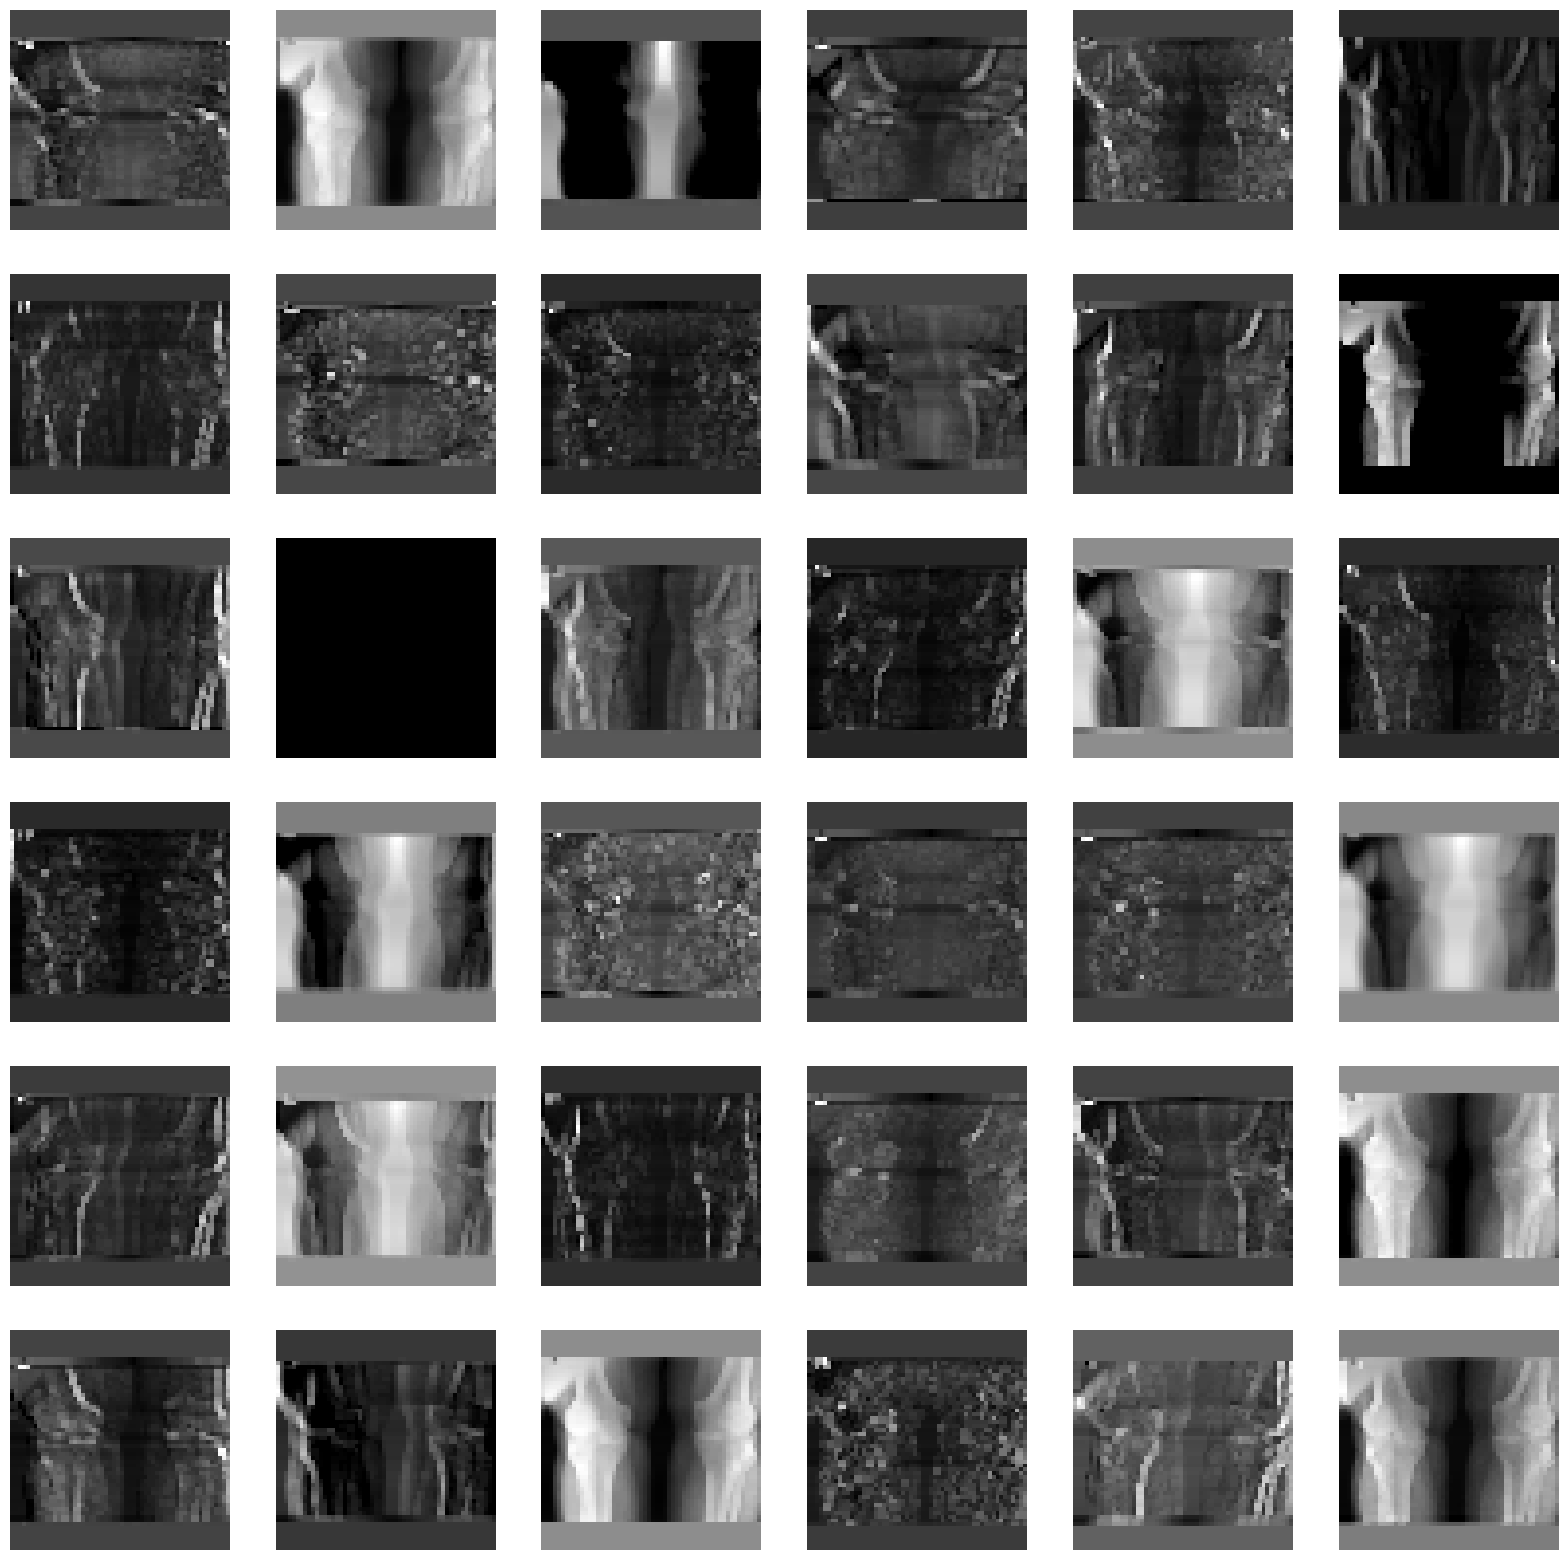

In [25]:
# show the feature map

# layer1 = model.conv1
feature_map = model.conv1.forward(input)
feature_map = model.bn1.forward(feature_map)
feature_map = model.relu.forward(feature_map)
feature_map = model.maxpool.forward(feature_map)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(normalize(feature_image[i]), cmap='gray')
    plt.axis('off') 

In [26]:
!nvidia-smi

Sat Jun 10 04:03:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 47%   68C    P2    55W / 125W |   4261MiB /  6144MiB |     65%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
del model, resnet_trainer, feature_map
gc.collect()
torch.cuda.empty_cache()


In [28]:
!nvidia-smi

Sat Jun 10 04:03:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 47%   68C    P2    57W / 125W |   3275MiB /  6144MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### inception_v4
- https://huggingface.co/docs/timm/models/inception-v4

--------------------Epoch 1--------------------
Train_accuracy: 49.75% | Train_loss: 213.9398
--------------------Epoch 2--------------------
Train_accuracy: 64.53% | Train_loss: 190.2914
--------------------Epoch 3--------------------
Train_accuracy: 64.53% | Train_loss: 178.6442
--------------------Epoch 4--------------------
Train_accuracy: 64.53% | Train_loss: 173.6970
--------------------Epoch 5--------------------
Train_accuracy: 64.53% | Train_loss: 170.9989
--------------------Epoch 6--------------------
Train_accuracy: 64.53% | Train_loss: 166.5986
--------------------Epoch 7--------------------
Train_accuracy: 64.53% | Train_loss: 161.8052
--------------------Epoch 8--------------------
Train_accuracy: 64.53% | Train_loss: 155.3477
--------------------Epoch 9--------------------
Train_accuracy: 64.53% | Train_loss: 149.6584
--------------------Epoch 10--------------------
Train_accuracy: 64.53% | Train_loss: 146.0282


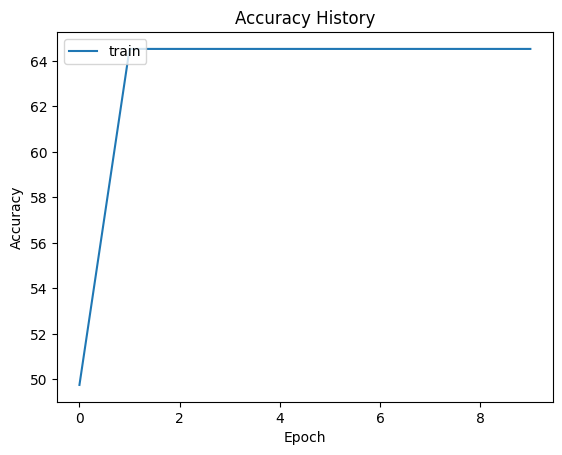

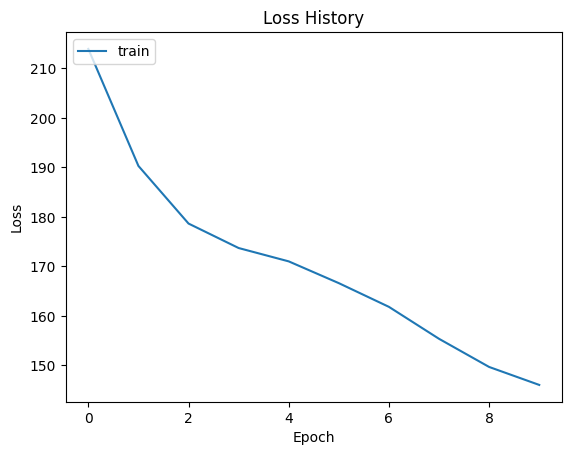

Accuracy on the test images: 58.33%
Inference time: 170.4894 milliseconds


In [29]:
model = timm.create_model('inception_v4', pretrained=True, num_classes=3).to(device)
inception_v4_trainer = trainer(model, train_loader, test_loader, EPOCHS, 5e-6)
inception_v4_trainer.train()
inception_v4_trainer.predict()

ConvNormAct(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU(inplace=True)
  )
)
torch.Size([1, 32, 111, 111])
(32, 111, 111)


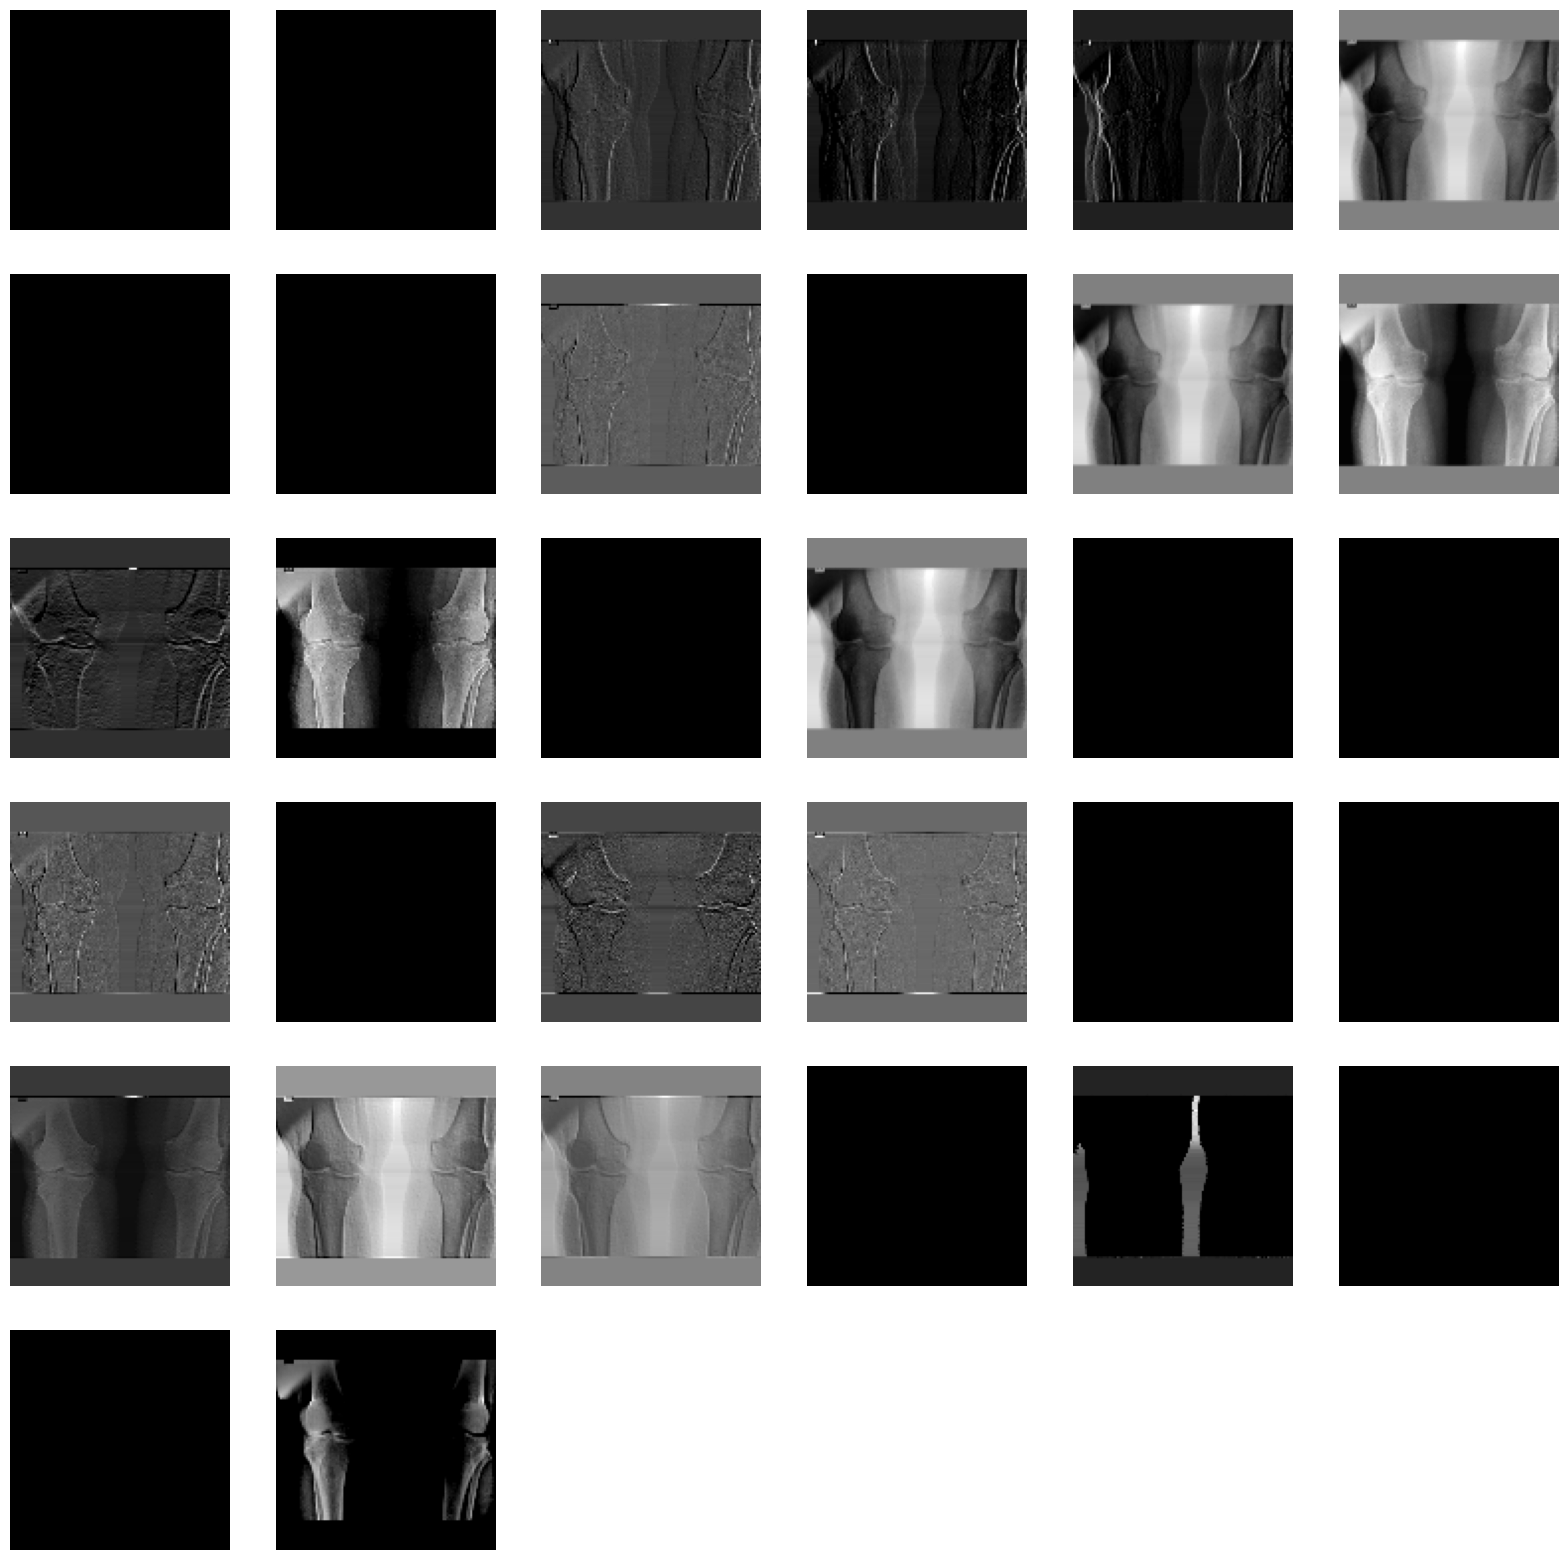

In [30]:
# Show the feature map
layer1 = model.features[0]
feature_map = layer1.forward(input)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(32):
    plt.subplot(6, 6, i+1)
    plt.imshow(normalize(feature_image[i]), cmap='gray')
    plt.axis('off') 


In [31]:
!nvidia-smi

Sat Jun 10 04:05:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 47%   67C    P2    55W / 125W |   4983MiB /  6144MiB |     38%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
del model, inception_v4_trainer, feature_map
gc.collect()
torch.cuda.empty_cache()

In [33]:
!nvidia-smi

Sat Jun 10 04:05:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 47%   67C    P2    58W / 125W |   3281MiB /  6144MiB |     38%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Visual Transformer

--------------------Epoch 1--------------------
Train_accuracy: 55.67% | Train_loss: 250.3332
--------------------Epoch 2--------------------
Train_accuracy: 55.67% | Train_loss: 205.3058
--------------------Epoch 3--------------------
Train_accuracy: 60.59% | Train_loss: 204.4383
--------------------Epoch 4--------------------
Train_accuracy: 61.58% | Train_loss: 198.4158
--------------------Epoch 5--------------------
Train_accuracy: 60.10% | Train_loss: 194.1390
--------------------Epoch 6--------------------
Train_accuracy: 61.08% | Train_loss: 194.6200
--------------------Epoch 7--------------------
Train_accuracy: 64.53% | Train_loss: 198.0321
--------------------Epoch 8--------------------
Train_accuracy: 62.07% | Train_loss: 189.3685
--------------------Epoch 9--------------------
Train_accuracy: 63.05% | Train_loss: 189.8072
--------------------Epoch 10--------------------
Train_accuracy: 64.53% | Train_loss: 184.9697


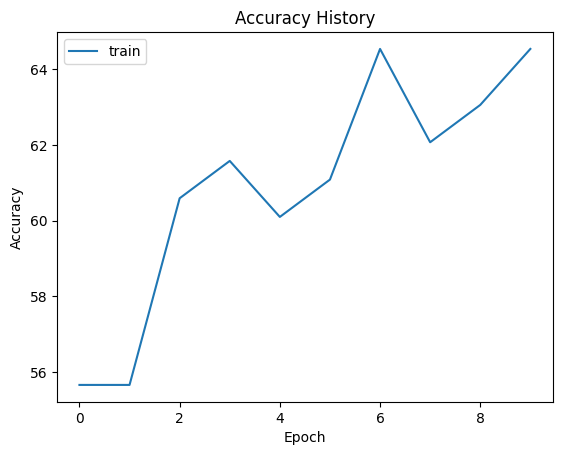

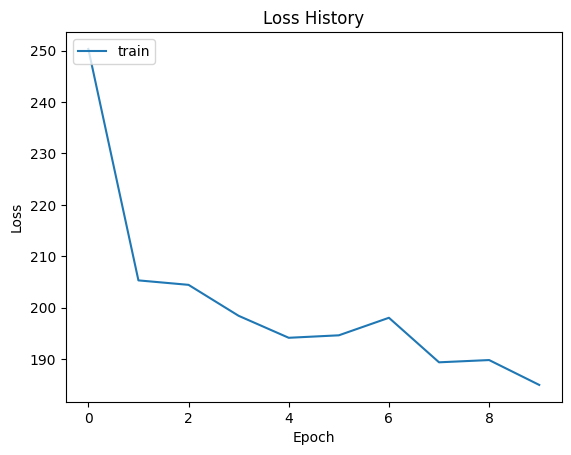

Accuracy on the test images: 63.89%
Inference time: 498.2743 milliseconds


In [34]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=3).to(device)
vit_trainer = trainer(model, train_loader, test_loader, EPOCHS, 1e-4)
vit_trainer.train()
vit_trainer.predict()

In [35]:
model.blocks

Sequential(
  (0): Block(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=768, out_features=2304, bias=True)
      (q_norm): Identity()
      (k_norm): Identity()
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=768, out_features=768, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (ls1): Identity()
    (drop_path1): Identity()
    (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (act): GELU(approximate='none')
      (drop1): Dropout(p=0.0, inplace=False)
      (norm): Identity()
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (drop2): Dropout(p=0.0, inplace=False)
    )
    (ls2): Identity()
    (drop_path2): Identity()
  )
  (1): Block(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
torch.Size([1, 768, 14, 14])
(768, 14, 14)


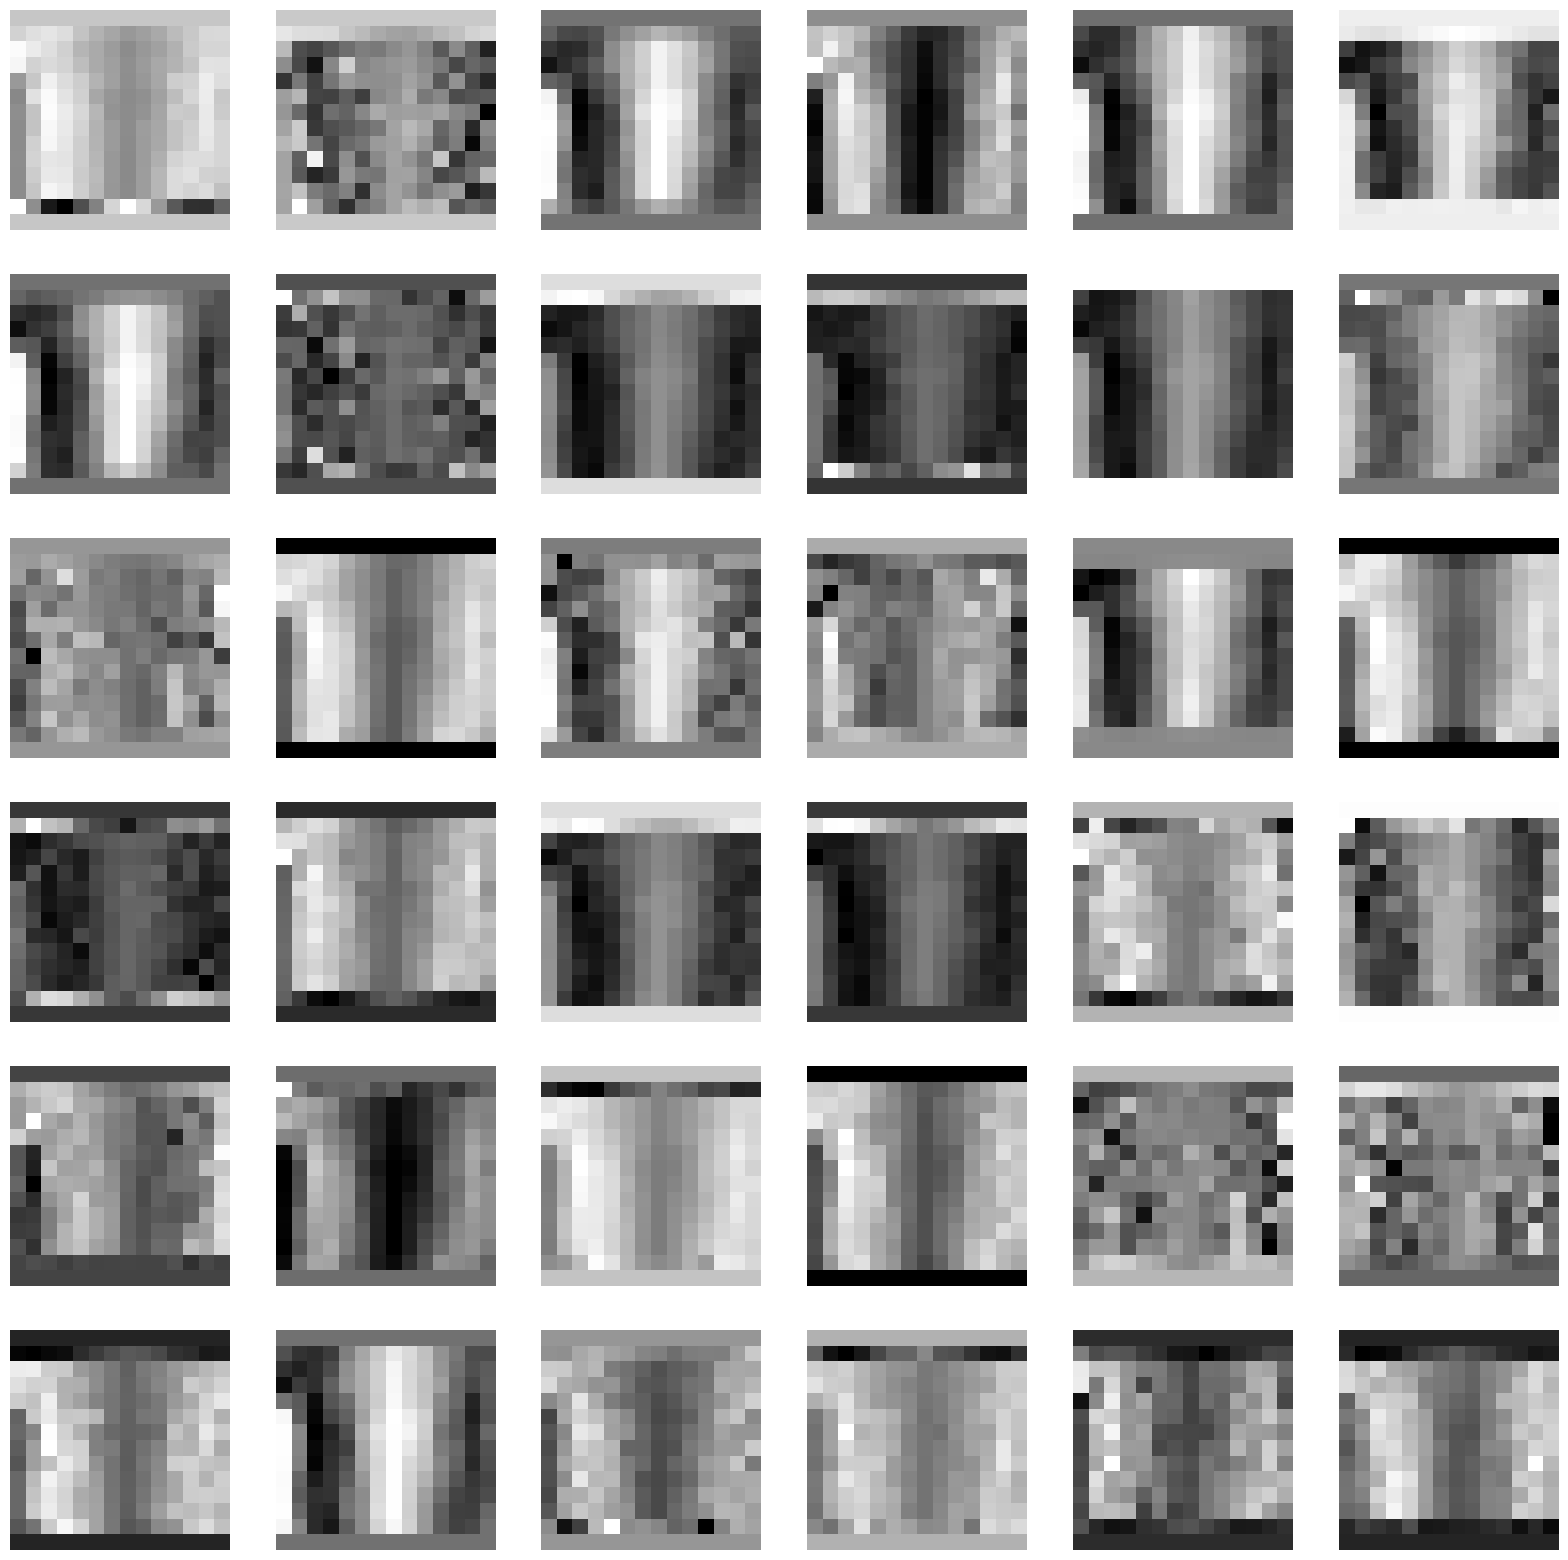

In [36]:

# Show the feature map
layer1 = model.patch_embed.proj
feature_map = layer1.forward(input)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(normalize(feature_image[i]), cmap='gray')
    plt.axis('off') 

In [37]:
!nvidia-smi

Sat Jun 10 04:08:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 49%   70C    P2    56W / 125W |   5729MiB /  6144MiB |     58%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [101]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=3)

In [115]:
torch.cuda.memory_stats()

OrderedDict([('active.all.allocated', 10182624),
             ('active.all.current', 848),
             ('active.all.freed', 10181776),
             ('active.all.peak', 3709),
             ('active.large_pool.allocated', 1823441),
             ('active.large_pool.current', 160),
             ('active.large_pool.freed', 1823281),
             ('active.large_pool.peak', 544),
             ('active.small_pool.allocated', 8359183),
             ('active.small_pool.current', 688),
             ('active.small_pool.freed', 8358495),
             ('active.small_pool.peak', 3165),
             ('active_bytes.all.allocated', 13998277478400),
             ('active_bytes.all.current', 2009789952),
             ('active_bytes.all.freed', 13996267688448),
             ('active_bytes.all.peak', 4099536896),
             ('active_bytes.large_pool.allocated', 12634825487360),
             ('active_bytes.large_pool.current', 1969618944),
             ('active_bytes.large_pool.freed', 12632855868416),
  

In [124]:
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Sat Jun 10 10:36:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 25%   47C    P3    38W / 125W |   3883MiB /  6144MiB |     31%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Swin-Transformer
- https://github.com/microsoft/Swin-Transformer

In [66]:
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=3).to(device)
swin_trainer = trainer(model, train_loader, test_loader, EPOCHS, 5e-5)
swin_trainer.train()
swin_trainer.predict()

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 5.80 GiB total capacity; 3.82 GiB already allocated; 20.75 MiB free; 3.97 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (d

torch.Size([1, 3, 224, 224])
Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
torch.Size([1, 128, 56, 56])
(128, 56, 56)


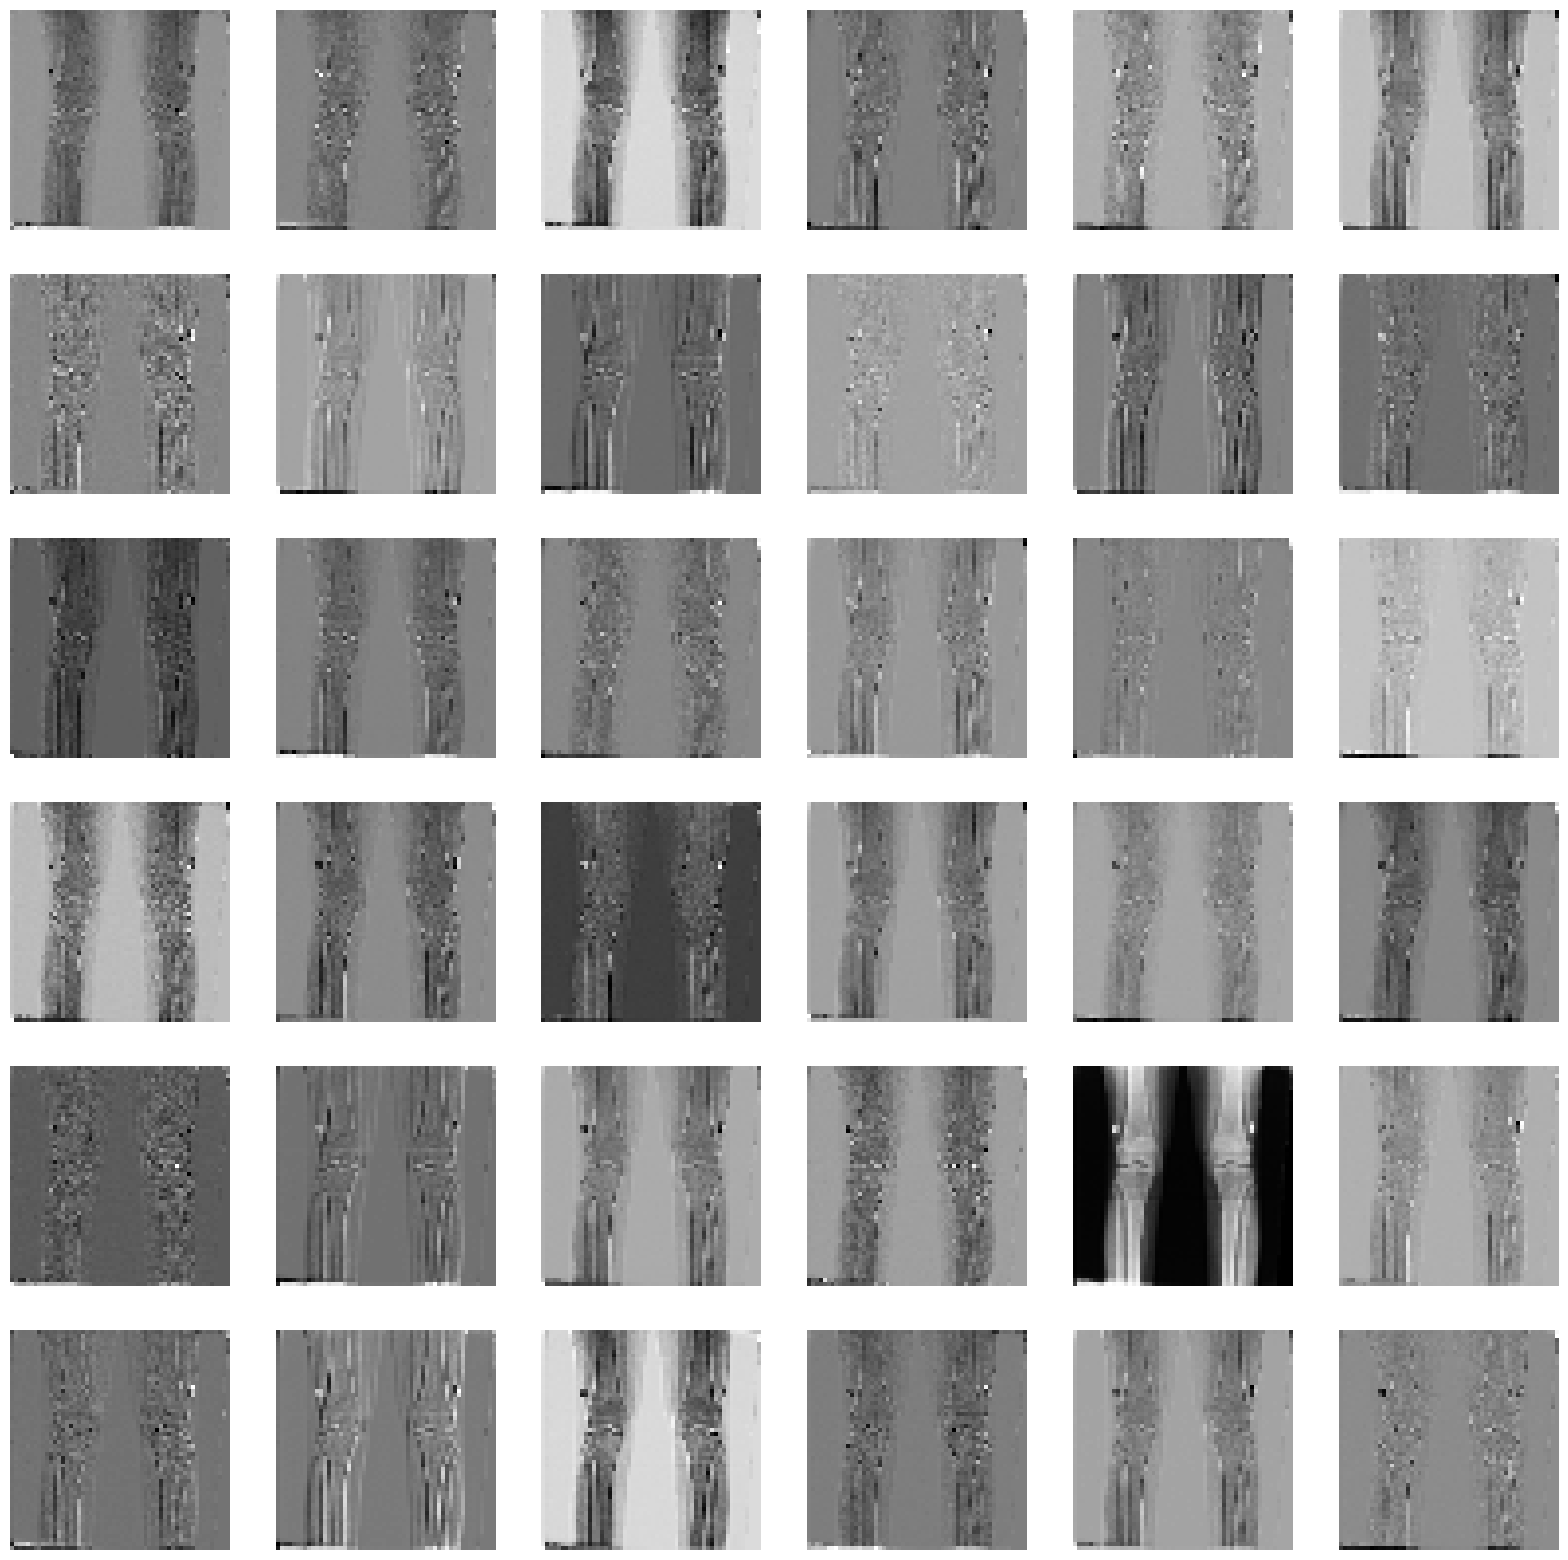

In [ ]:
# Show the feature map
layer1 = model.patch_embed.proj
feature_map = layer1.forward(input)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(normalize(feature_image[i]), cmap='gray')
    plt.axis('off') 

In [ ]:
!nvidia-smi

In [ ]:
del model, swin_trainer, feature_map
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi